In [50]:
import deconV as dv
import scout

import glob, tqdm, time, os
import torch
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams

import pandas as pd
import numpy as np
import scanpy as sc
import scvi
import seaborn as sns
import tqdm
import scout

import plotly.express as px

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [51]:
params = {
    "cell_type_key": "cellType",
    "fig_fmt": "png",

    # "selected_ct": ["alpha", "delta", "gamma", "beta"],
    # "bulk_file": "../../data/xin/bulk.tsv",
    # "ref_annot_file": "../../data/xin/pdata.tsv",
    # "ref_file": "../../data/xin/sc.tsv",

    "selected_ct": ["0", "1", "2"],
    "bulk_file": "../../data/GSE136148/bulk.tsv",
    "ref_annot_file": "../../data/GSE136148/pdata.tsv",
    "ref_file": "../../data/GSE136148/sc.tsv",

    # "selected_ct": ["alpha", "delta", "gamma", "beta", "ductal", "acinar"],
    # "bulk_file": "../../data/pancreas/bulk.tsv",
    # "ref_annot_file": "../../data/pancreas/pdata.tsv",
    # "ref_file": "../../data/pancreas/sc.tsv",

    # "selected_ct": ["alpha", "delta", "gamma", "beta", "ductal", "acinar"],
    # "bulk_file": "../../data/mouse/bulk.tsv",
    # "ref_annot_file": "../../data/mouse/pdata.tsv",
    # "ref_file": "../../data/mouse/sc.tsv",
    
    "outdir": "out",
    "figsize": (8,8),
    "dpi": 80,
}

sc.settings.set_figure_params(dpi=80, facecolor='white')
plt.rc("patch", edgecolor="black", facecolor="royalblue", linewidth=1.0)
plt.rc("axes", facecolor="white", edgecolor="black", linewidth=1.0)

sc.settings.verbosity = 0

In [52]:
sadata = dv.tl.read_data(params["ref_file"])
print(f"scRNA-seq data - cells: {sadata.shape[0]}, genes: {sadata.shape[1]}")

scRNA-seq data - cells: 3022, genes: 33694


In [53]:
print("Reading pheno data...")
pheno_df = pd.read_csv(params["ref_annot_file"], sep="\t", index_col=0)
pheno_df.index.name = None

Reading pheno data...


In [54]:
common_cells = list(set(pheno_df.index.tolist()) & set(sadata.obs_names.tolist()))
len(common_cells)

3022

In [55]:
sadata = sadata[common_cells, :].copy()
pheno_df = pheno_df.loc[common_cells, :].copy()
sadata.obs[params["cell_type_key"]] = pheno_df[params["cell_type_key"]].tolist()
sadata.obs.groupby(params["cell_type_key"]).size()

cellType
0    1988
1     686
2     319
3      29
dtype: int64

In [56]:
print("Reading bulk data...")
bulk_df = pd.read_csv(params["bulk_file"], sep="\t", index_col=None)
if bulk_df.iloc[:,0].dtype == "O":
    bulk_df.set_index(bulk_df.columns[0], inplace=True)
print(f"bulk RNA-seq data - samples: {bulk_df.shape[0]}, genes: {bulk_df.shape[1]}")

Reading bulk data...
bulk RNA-seq data - samples: 1, genes: 58387


In [57]:
if params["selected_ct"] is not None and len(params["selected_ct"]) > 0:
    sadata = sadata[sadata.obs[params["cell_type_key"]].astype("str").isin(params["selected_ct"]), :].copy()

sadata.obs[params["cell_type_key"]] = sadata.obs[params["cell_type_key"]].astype("category")
sadata.obs.groupby(params["cell_type_key"]).size()

cellType
0    1988
1     686
2     319
dtype: int64

In [58]:
sc.pp.filter_cells(sadata, min_genes=200)
sc.pp.filter_genes(sadata, min_cells=3)
adata = dv.tl.combine(sadata, bulk_df)
scout.tl.scale_log_center(adata, target_sum=None, exclude_highly_expressed=False)

scRNA-seq data - cells: 2993, genes: 18597
bulk RNA-seq data - samples: 1, genes: 18597


/home/lutrarutra/.pyenv/versions/3.10.9/envs/lst/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



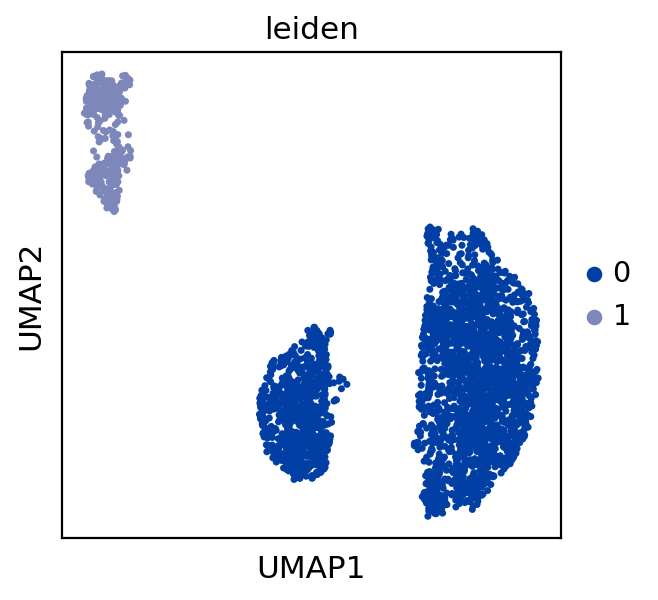

In [71]:
sc.tl.leiden(adata, resolution=0.001, key_added="leiden")
sc.pl.umap(adata, color="leiden")

In [63]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)
# sc.external.tl.trimap(adata)
# scout.tl.sub_cluster(adata, "cellType")
scout.ply.subplots([
    scout.ply.projection(adata, hue="cellType", obsm_layer="X_umap"),
    # scout.ply.projection(adata, hue="sub_type", obsm_layer="X_umap"),
    scout.ply.projection(adata, hue="leiden", obsm_layer="X_umap"),
], subplot_titles=["Cell Type", "Sub Type (leiden)"])

IndexError: list index out of range

In [11]:
decon = dv.DeconV(adata, cell_type_key="cellType", sub_type_key="sub_type", layer="ncounts")

/home/lutrarutra/Documents/dev/fimm/scout/scout/tools.py:168: RuntimeWarning:

invalid value encountered in divide

/home/lutrarutra/Documents/dev/fimm/scout/scout/tools.py:187: RuntimeWarning:

Mean of empty slice

/home/lutrarutra/Documents/dev/fimm/scout/scout/tools.py:188: RuntimeWarning:

Mean of empty slice



Added results to: adata.uns['de']['sub_type']


In [12]:
# res = decon.adata.uns["de"]["cellType"]["0 vs. rest"]
# scout.ply.scatter_marker_scores(res)

In [13]:
decon.filter_outliers(dropout_factor_quantile=1.0, pseudobulk_lims=(-10,10), aggregate="max")

print(adata.varm["dropout_outlier"].sum())
print(adata.varm["pseudobulk_outlier"].sum(0))

print(adata.varm["outlier"].sum(0))

3
[29]
[32]


In [14]:
# scout.pl.pseudo_bulk_plot(adata, style="pseudobulk_outlier")

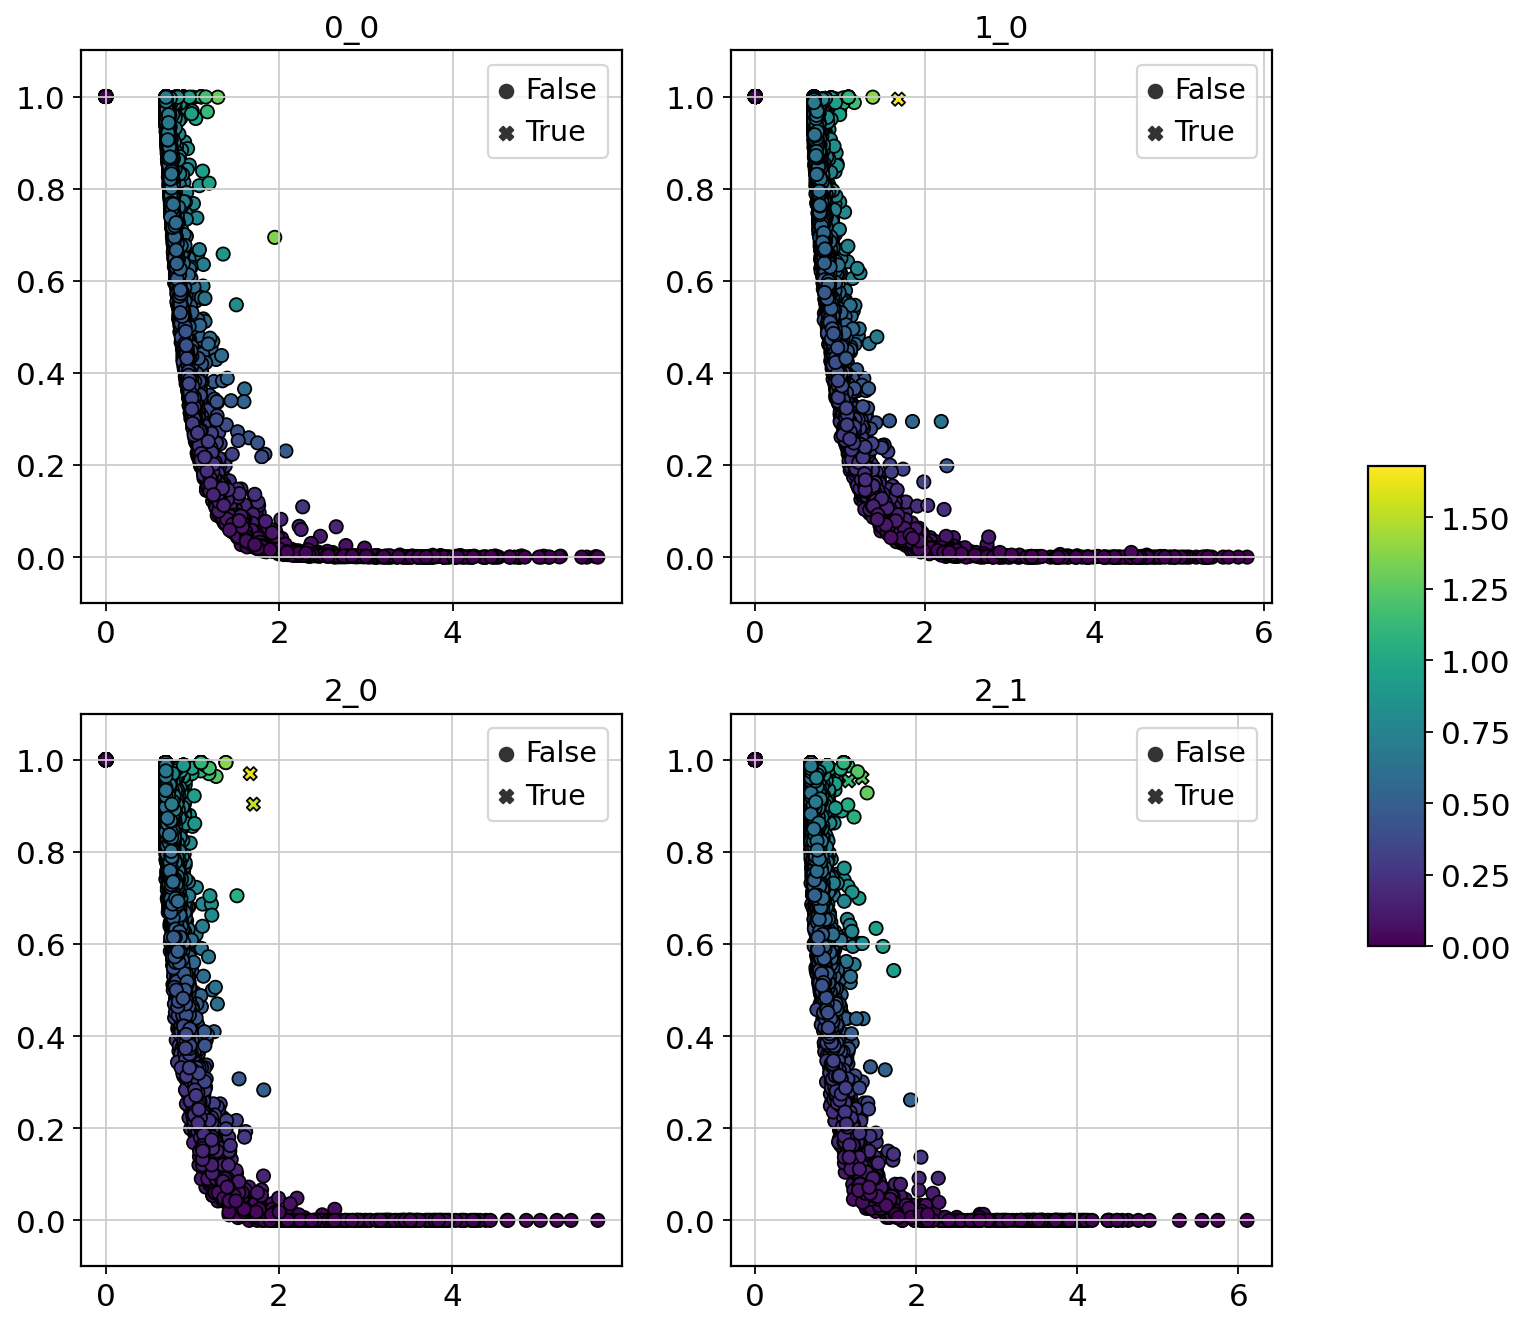

In [15]:
scout.pl.dropout_plot(adata, decon.label_key, style="dropout_outlier")

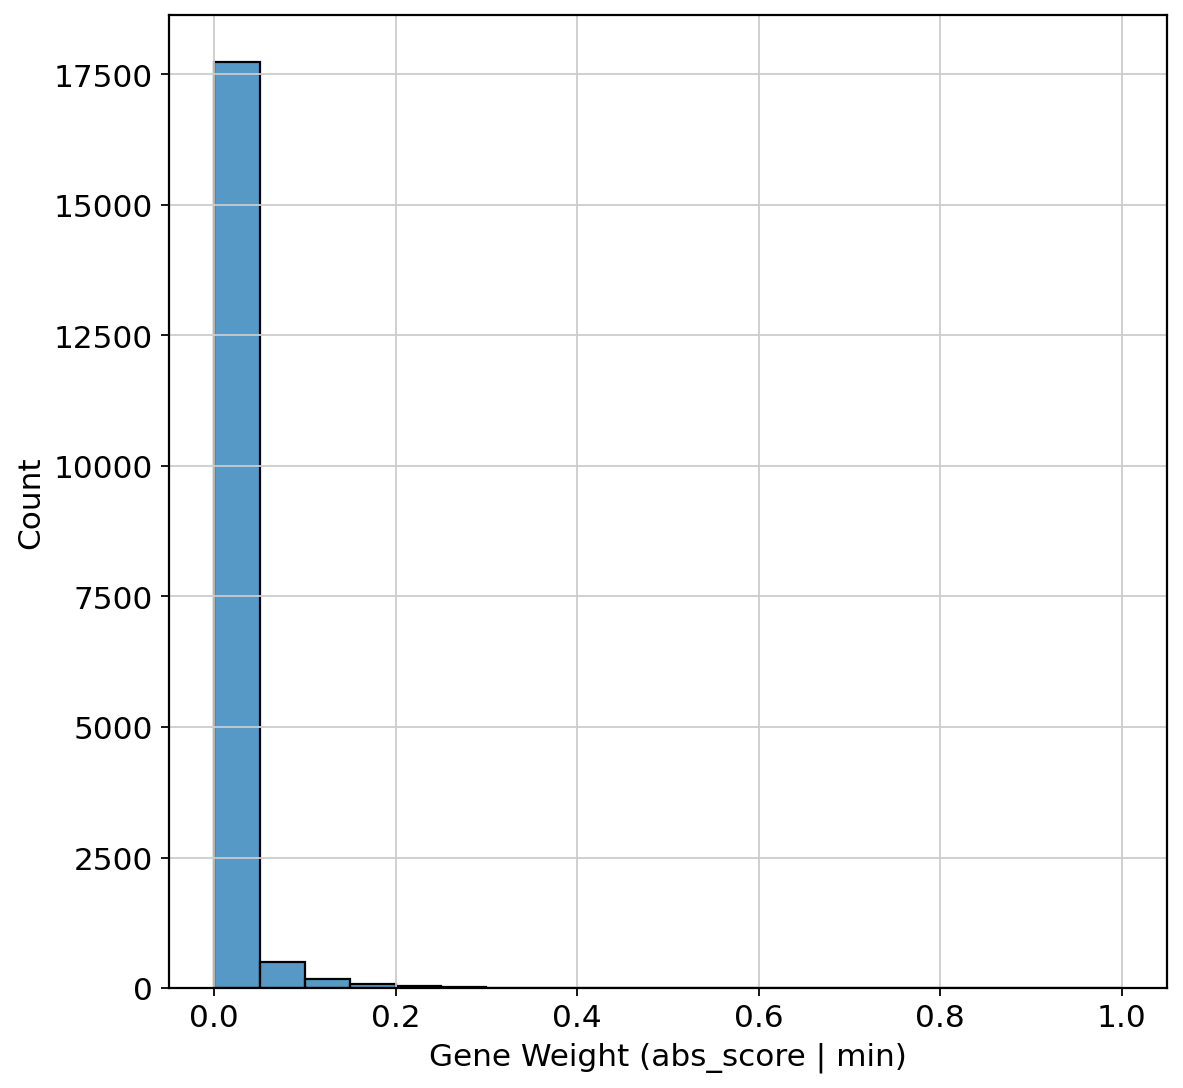

/home/lutrarutra/Documents/dev/fimm/deconv/deconV/DeconV.py:159: RuntimeWarning:

divide by zero encountered in divide



In [26]:
decon.init_dataset(
    weight_type="abs_score", weight_agg="min",
    inverse_weight=False, log_weight=False, quantiles=(0, 1)
)

In [27]:
loc, _ = decon.get_signature()

In [28]:
adata.varm

AxisArrays with keys: bulk, pseudo, pseudo_factor, PCs, mu_expression_sub_type, var_expression_sub_type, cv_sub_type, log_mu_expression_sub_type, log_var_expression_sub_type, dropout_sub_type, nan_mu_expression_sub_type, nan_log_mu_expression_sub_type, dropout_weight_sub_type, dropout_outlier, pseudobulk_outlier, outlier, gene_weights

In [44]:
adata.var.iloc[adata.varm["gene_weights"].argsort()[-10:]].index

Index(['S100A4', 'PTMA', 'H3F3A', 'RPLP1', 'RPL37A', 'SERF2', 'CHCHD2', 'FTL',
       'S100A6', 'SEC61G'],
      dtype='object')

In [47]:
scout.ply.heatmap(adata, adata.var.iloc[adata.varm["gene_weights"].argsort()[-20:]].index, "cellType", cluster_cells_by="barcode")


In [29]:
px.scatter(
    x=adata.varm[f"cv_{decon.label_key}"].mean(1),
    # x=adata.varm["pseudo"].flatten(),
    y=adata.varm["bulk"][:, 0].flatten(),
    color=adata.varm["gene_weights"],
    symbol=(~(loc.sum(1) == 0)).numpy(),
    log_x=True, log_y=True,
    hover_data={"gene": adata.var_names.tolist()},
)

Sample: 0/1 | Using 2137 genes (11.5%)


100%|██████████| 5000/5000 [00:03<00:00, 1292.81it/s, loss=830.9, p=0.62 0.29 0.09 0.01, lib_size=1228.0]


0: 0.619 | 1: 0.286 | 2: 0.095 | 


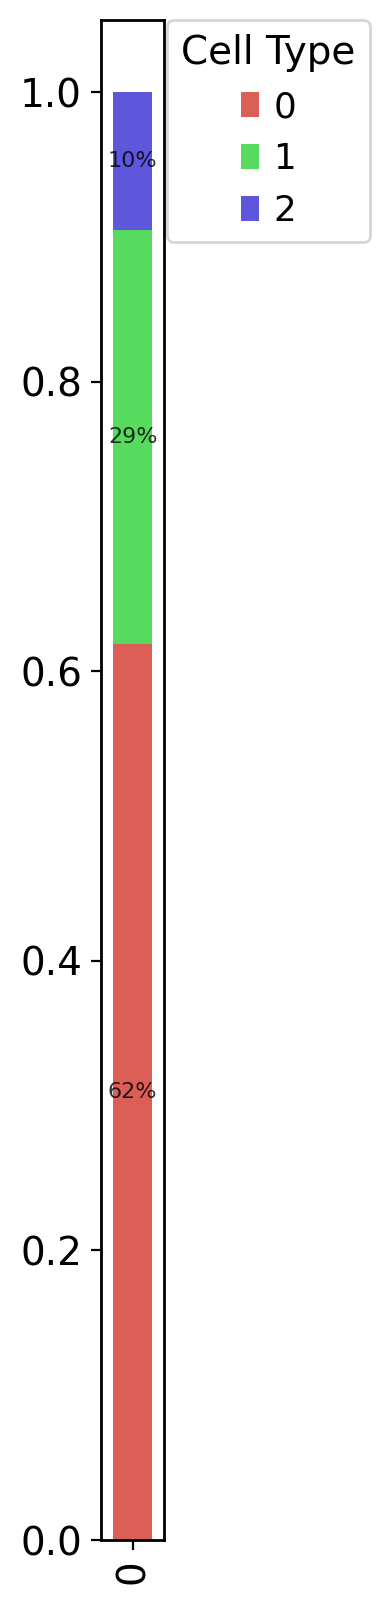

In [30]:
est_df = decon.deconvolute(
    model_type="poisson",
    num_epochs=5000,
    lr=0.01,
    use_outlier_genes=False
)

<AxesSubplot: >

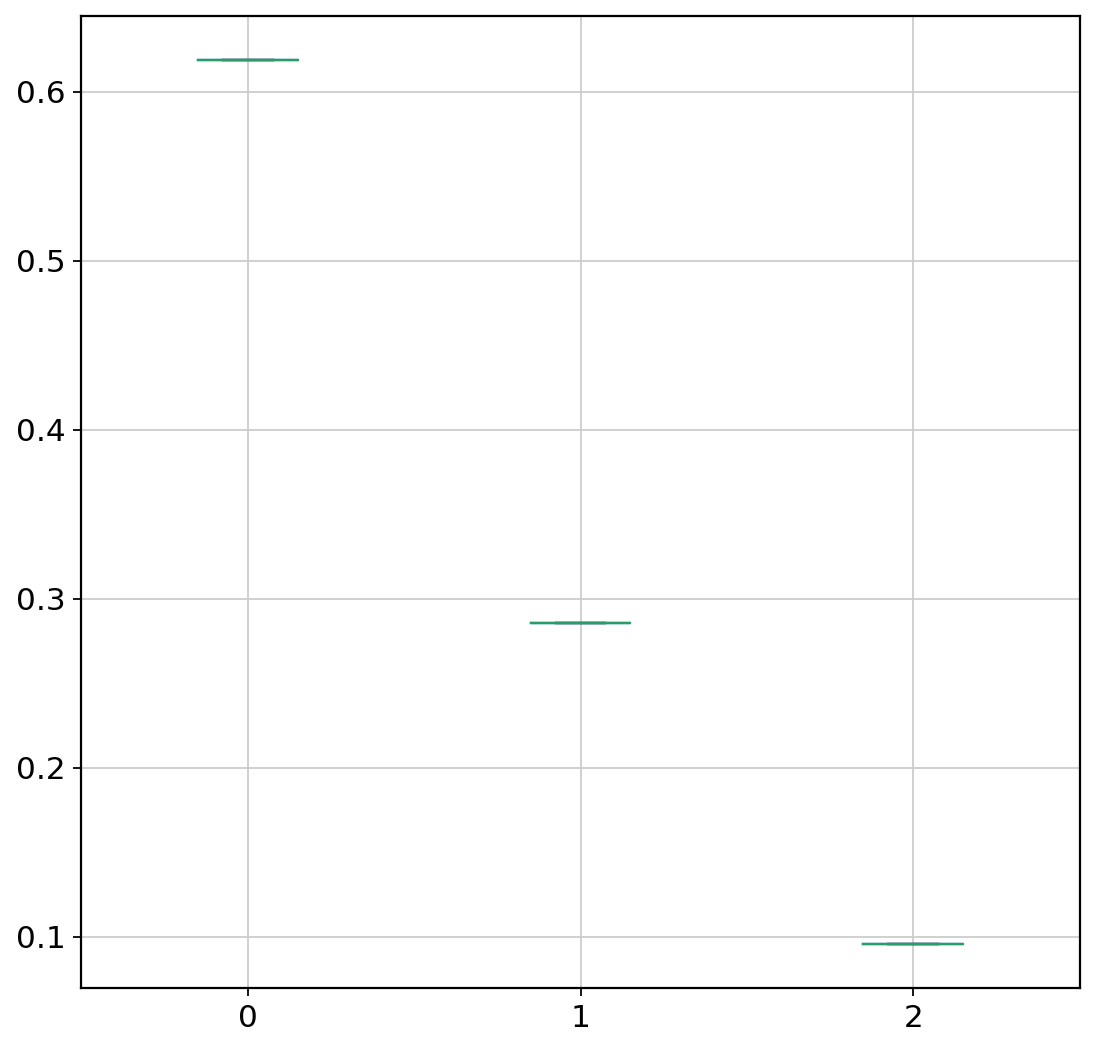

In [31]:
est_df.boxplot(figsize=(8,8))

In [32]:
true_df = pd.read_csv("../../data/xin/true.tsv", sep="\t", index_col=0)

In [33]:
est_df

0         1         2
0  0.61874  0.285803  0.095457

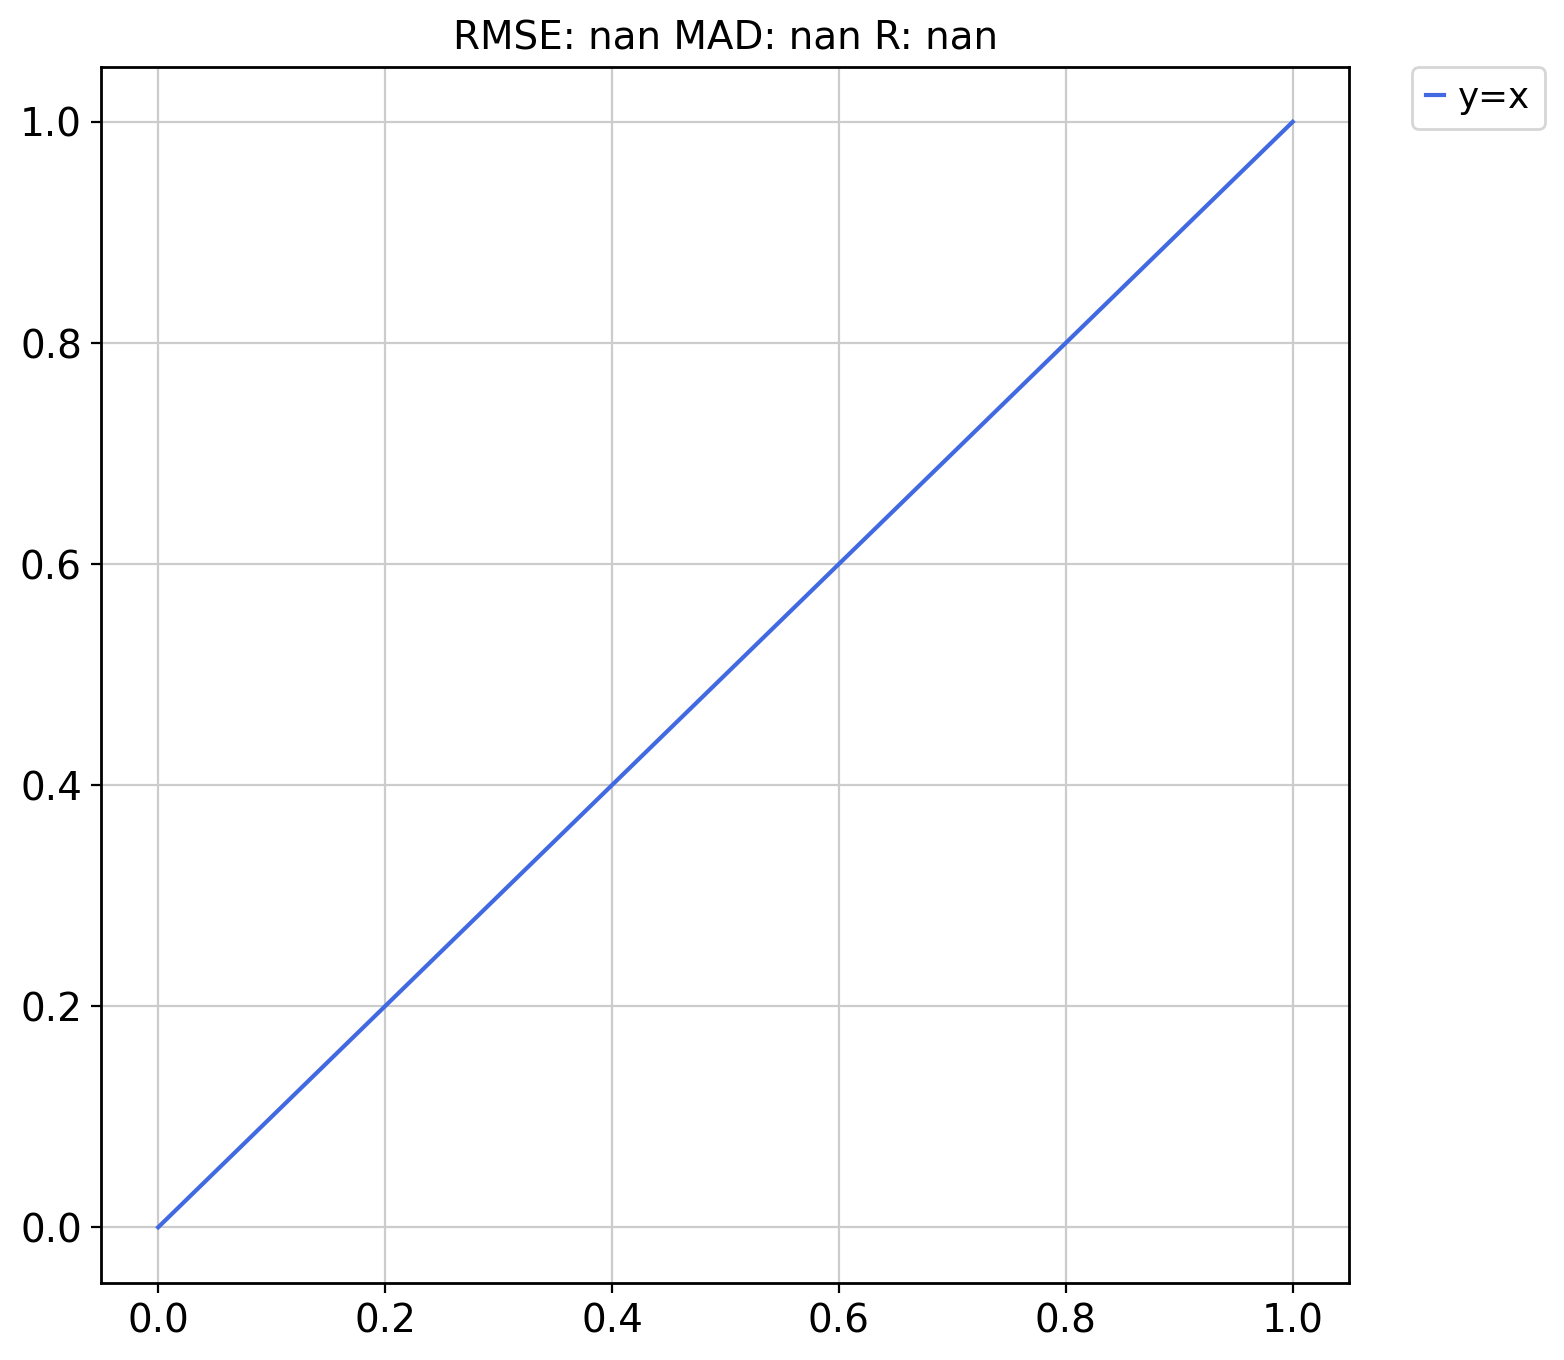

In [34]:
dv.pl.scatter_check(true_df, est_df, style="sample")

In [35]:
pd.DataFrame({
    "MuSiC": [0.10, 0.06, 0.94],
    "NNLS": [0.17, 0.12, 0.82],
    "BSEQ-sc": [0.21, 0.15, 0.79],
    "CIBERSORT": [0.21, 0.15, 0.76],
    "Normal": [0.16, 0.10, 0.79],
    "Poisson": [0.06, 0.05, 0.97]},
    index=["RMSD", "mAD", "R"]
)

MuSiC  NNLS  BSEQ-sc  CIBERSORT  Normal  Poisson
RMSD   0.10  0.17     0.21       0.21    0.16     0.06
mAD    0.06  0.12     0.15       0.15    0.10     0.05
R      0.94  0.82     0.79       0.76    0.79     0.97